In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Id, Response만 읽어서 메모리 절약
df_ids = pd.read_csv(
    'train_numeric.csv',
    usecols=['Id','Response'],
    dtype={'Response':'int8'}
)

# leakage 방지위해 미리 분리
ids = df_ids['Id']
responses = df_ids['Response']

# 80% 학습, 20% 검증 
train_ids, val_ids, y_train_ids, y_val_ids = train_test_split(
    ids, responses,
    stratify=responses,
    test_size=0.2,
    random_state=42
)

In [3]:
def sample_ids(id_series, resp_series, factor=20, seed=42):
    """
    id_series: pd.Series of Id
    resp_series: pd.Series of Response (0/1)
    factor: 정상 대비 불량 몇 배 뽑을지
    """
    sr = pd.Series(resp_series.values, index=id_series.values)
    # 불량 Id 전부
    bad = sr[sr == 1].index
    good = sr[sr == 0].index.to_series().sample(
        n=len(bad) * factor, random_state=seed
    )
    return set(bad) | set(good)

# Train/Val 각각에 대해 샘플링 ID 집합 생성
train_sel_ids = sample_ids(train_ids, y_train_ids, factor=20, seed=42)
val_sel_ids   = sample_ids(val_ids,   y_val_ids,   factor=20, seed=42)

In [4]:
# processing_time 파생변수 계산
proc_parts = []
sel_union = train_sel_ids | val_sel_ids

for chunk in pd.read_csv(
        'train_date.csv',
        dtype={'Id':'int32'},
        chunksize=50000
    ):
    # 필요한 Id만 필터
    sub = chunk[chunk['Id'].isin(sel_union)]
    if sub.empty:
        continue

    date_vals = (
        sub.drop('Id', axis=1)
           .astype('float64')
           .apply(lambda c: pd.to_datetime(c, origin='1900-01-01', unit='D'))
    )
    
    start = date_vals.min(axis=1)
    end   = date_vals.max(axis=1)

 
    proc_parts.append(pd.DataFrame({
        'Id': sub['Id'].values,
        'processing_time': (end - start).dt.total_seconds().values
    }))

# 작은 테이블로 합치기
proc_df = pd.concat(proc_parts, ignore_index=True)

In [5]:
# Train 데이터프레임 구성 (Numeric + processing_time)

train_parts = []
for chunk in pd.read_csv(
        'train_numeric.csv',
        dtype='float32',
        chunksize=50000
    ):
    sub = chunk[chunk['Id'].isin(train_sel_ids)]
    if sub.empty:
        continue

    merged = sub.merge(proc_df, on='Id', how='left')
    train_parts.append(merged)

# 하나의 DataFrame으로
train_df = pd.concat(train_parts, ignore_index=True)

In [6]:
# Val 데이터프레임 구성 (Numeric + processing_time)

val_parts = []
for chunk in pd.read_csv(
        'train_numeric.csv',
        dtype='float32',
        chunksize=50000
    ):
    sub = chunk[chunk['Id'].isin(val_sel_ids)]
    if sub.empty:
        continue

    merged = sub.merge(proc_df, on='Id', how='left')
    val_parts.append(merged)

val_df = pd.concat(val_parts, ignore_index=True)

In [7]:
# 결측치 99% 이상 컬럼 제거 


miss_ratio = train_df.isna().mean()
drop_cols  = miss_ratio[miss_ratio >= 0.99].index.tolist()

# Train/Val 동일하게 피쳐 제거
train_df.drop(columns=drop_cols, inplace=True)
val_df.drop(columns=drop_cols, inplace=True)


X_train = train_df.drop(columns=['Id','Response'])
y_train = train_df['Response']
X_val   = val_df.drop(columns=['Id','Response'])
y_val   = val_df['Response']

In [12]:
print("X_train.shape : ", X_train.shape)
print("y_train.shape : ", y_train.shape)
print("X_val.shape : ", X_val.shape)
print("y_val.shape : ", y_val.shape)

X_train.shape :  (115563, 742)
y_train.shape :  (115563,)
X_val.shape :  (28896, 742)
y_val.shape :  (28896,)


In [10]:
# 모델 학습·평가 및 feature importance 분석

import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score

# XGboost 기준으로 학습
xgb = XGBClassifier(
    n_estimators=100, max_depth=6,
    use_label_encoder=False, eval_metric='auc',
    random_state=42
)
xgb.fit(X_train, y_train)
proba_xgb = xgb.predict_proba(X_val)[:,1]
print("XGB ROC AUC:", roc_auc_score(y_val, proba_xgb))

# F1 기준으로 최적 threshold 찾기
best_thr, best_f1 = 0.5, 0
for t in np.arange(0.1, 0.99, 0.01):
    f1 = f1_score(y_val, (proba_xgb > t).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, t
print(f"XGB Best F1: {best_f1:.4f} @thr={best_thr:.2f}")

# LightGBM 기준으로 학습
lgbm = LGBMClassifier(
    class_weight='balanced', n_estimators=100,
    random_state=42, n_jobs=-1
)
lgbm.fit(X_train, y_train)
proba_lgb = lgbm.predict_proba(X_val)[:,1]
print("LGB ROC AUC:", roc_auc_score(y_val, proba_lgb))

D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB ROC AUC: 0.6930483432767712
XGB Best F1: 0.3058 @thr=0.21
[LightGBM] [Info] Number of positive: 5503, number of negative: 110060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99965
[LightGBM] [Info] Number of data points in the train set: 115563, number of used features: 742
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGB ROC AUC: 0.7091825395484046


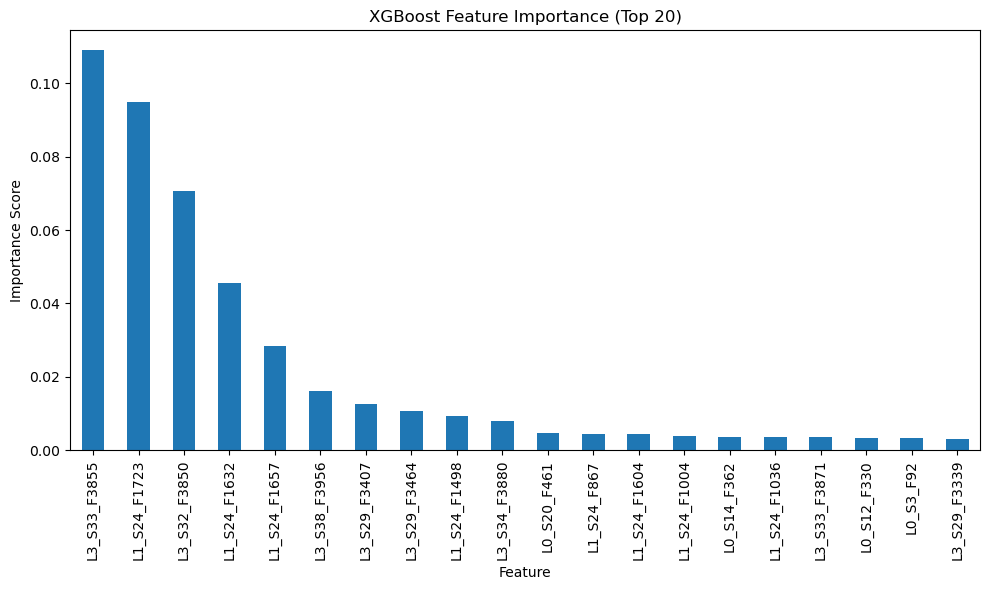

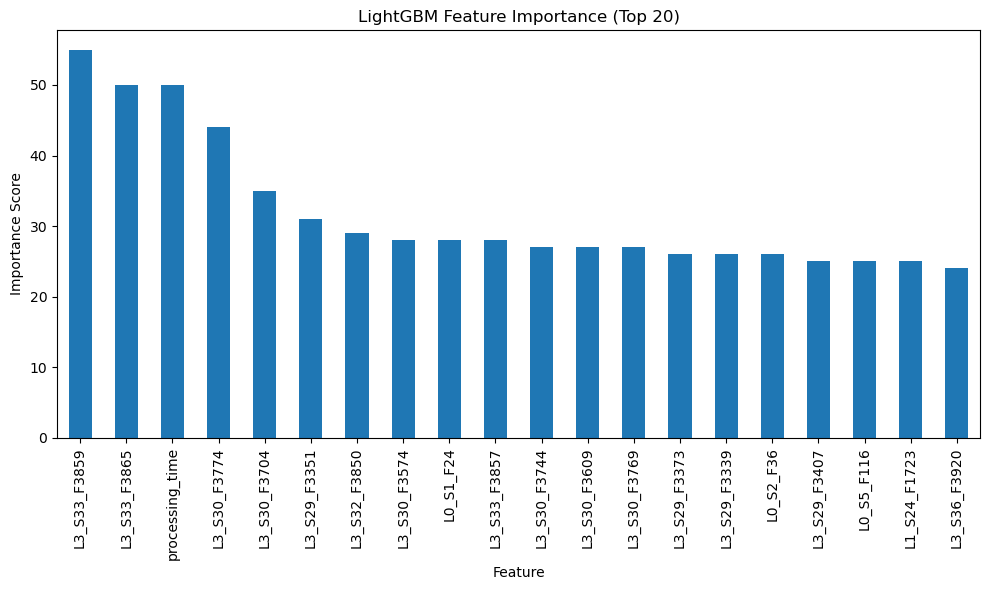

Number of union features: 90
Union feature list:
['L0_S0_F16', 'L0_S0_F18', 'L0_S0_F2', 'L0_S0_F20', 'L0_S12_F330', 'L0_S12_F350', 'L0_S13_F354', 'L0_S14_F362', 'L0_S1_F24', 'L0_S1_F28', 'L0_S20_F461', 'L0_S21_F527', 'L0_S22_F596', 'L0_S23_F639', 'L0_S23_F643', 'L0_S2_F36', 'L0_S2_F64', 'L0_S3_F100', 'L0_S3_F80', 'L0_S3_F92', 'L0_S5_F116', 'L0_S6_F132', 'L0_S8_F144', 'L1_S24_F1004', 'L1_S24_F1036', 'L1_S24_F1072', 'L1_S24_F1098', 'L1_S24_F1498', 'L1_S24_F1573', 'L1_S24_F1575', 'L1_S24_F1581', 'L1_S24_F1604', 'L1_S24_F1632', 'L1_S24_F1637', 'L1_S24_F1657', 'L1_S24_F1723', 'L1_S24_F1783', 'L1_S24_F1803', 'L1_S24_F1818', 'L1_S24_F1844', 'L1_S24_F1846', 'L1_S24_F867', 'L1_S24_F882', 'L1_S24_F902', 'L1_S25_F2106', 'L1_S25_F2176', 'L2_S26_F3040', 'L2_S26_F3073', 'L2_S27_F3166', 'L3_S29_F3315', 'L3_S29_F3327', 'L3_S29_F3339', 'L3_S29_F3348', 'L3_S29_F3351', 'L3_S29_F3357', 'L3_S29_F3373', 'L3_S29_F3379', 'L3_S29_F3407', 'L3_S29_F3427', 'L3_S29_F3436', 'L3_S29_F3464', 'L3_S29_F3479', 'L3_S30_F

In [13]:
# XGBoost, LightGBM 중요도 시각화 후 합집합 추출해서 시각화
import matplotlib.pyplot as plt
import pandas as pd


imp_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_lgb = pd.Series(lgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# XGBoost 기준 상위 20개 시각화
plt.figure(figsize=(10, 6))
imp_xgb.head(20).plot(kind='bar')
plt.title('XGBoost Feature Importance (Top 20)')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# LightGBM 기준 상위 20개 시각화
plt.figure(figsize=(10, 6))
imp_lgb.head(20).plot(kind='bar')
plt.title('LightGBM Feature Importance (Top 20)')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# 합집합 추출
xgb_top50 = set(imp_xgb.head(50).index)
lgb_top50 = set(imp_lgb.head(50).index)
union_top = sorted(xgb_top50 | lgb_top50)

print(f"Number of union features: {len(union_top)}")
print("Union feature list:")
print(union_top)

In [30]:
# feature importance 기반으로 상위 700개 피처추출하고 합집합 추출
N = 700
imp_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).nlargest(N)
imp_lgb = pd.Series(lgbm.feature_importances_, index=X_train.columns).nlargest(N)
xgb_top   = set(imp_xgb.index)
lgb_top   = set(imp_lgb.index)
union_top = xgb_top | lgb_top
print(f"XGB_top{N}: {len(xgb_top)}, LGB_top{N}: {len(lgb_top)}, Union: {len(union_top)}")

XGB_top700: 700, LGB_top700: 700, Union: 706


In [36]:
# Top700 개별 추출
# 이미 imp_xgb, imp_lgb이 계산되어 있음

xgb_top700 = set(imp_xgb.head(700).index)
lgb_top700 = set(imp_lgb.head(700).index)


union_top700 = sorted(xgb_top700 | lgb_top700)

# 사용할 700개 피쳐 CSV로 저장
pd.Series(union_top700, name='feature').to_csv('top700_union_features.csv', index=False)

X_sel = X_train[union_top700].copy()
X_val_sel = X_val[union_top700].copy()

print(f"Selected {len(union_top700)} features saved to top700_union_features.csv")
print("Train shape:", X_sel.shape, "Val shape:", X_val_sel.shape)


Selected 706 features saved to top700_union_features.csv
Train shape: (115563, 706) Val shape: (28896, 706)


In [47]:
# Under-sampling + XGBoost
from sklearn.utils import resample
from sklearn.metrics import f1_score
import pandas as pd

# Train 데이터 언더샘플링
df_tr = pd.concat([X_sel, y_train], axis=1)
pos   = df_tr[df_tr.Response == 1]
neg   = df_tr[df_tr.Response == 0]
neg_down = resample(
    neg,
    replace=False,
    n_samples=len(pos),
    random_state=42
)
df_under = pd.concat([pos, neg_down], ignore_index=True)

X_under = df_under[union_top500].copy()
y_under = df_under.Response

model_under = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model_under.fit(X_under, y_under)

X_val_test = X_val_sel[union_top500].copy()
y_pred_under = model_under.predict(X_val_test)

f1_under = f1_score(y_val, y_pred_under)
print(f"Under-sampling F1 score: {f1_under:.4f}")

D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Under-sampling F1 score: 0.1494


In [48]:
# 소수 클래스에 가중치 + XGBoost 
from collections import Counter
from sklearn.metrics import f1_score


counter = Counter(y_train)

scale_pos_weight = counter[0] / counter[1]

model_weight = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model_weight.fit(X_sel, y_train)

y_pred_weight = model_weight.predict(X_val_sel)

f1_weight = f1_score(y_val, y_pred_weight)
print(f"scale_pos_weight F1 score: {f1_weight:.4f}")

D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


scale_pos_weight F1 score: 0.1903


In [49]:
# 두 방법 비교 결과 scale_pos_weight 적용한 결과가 더 우수함
# sclae_pos_weight 적용은 확정 ..
# 이제 XGBoost, LightGBM 비교 (99% 기준으로 제거했더라도 결측치가 남아 있으므로 트리계열 모델로 선정해서비교)

In [50]:
# LightGBM 기준 scale_pos_weight  

counter = Counter(y_train)
# 정상 클래스(0) 개수 / 불량 클래스(1) 개수
scale_pos_weight = counter[0] / counter[1]

lgbm_weight = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

lgbm_weight.fit(X_sel, y_train)

y_pred_lgb_weight = lgbm_weight.predict(X_val_sel)
f1_lgb_weight = f1_score(y_val, y_pred_lgb_weight)

print(f"LightGBM scale_pos_weight F1 score: {f1_lgb_weight:.4f}")


[LightGBM] [Info] Number of positive: 5503, number of negative: 110060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99679
[LightGBM] [Info] Number of data points in the train set: 115563, number of used features: 706
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047619 -> initscore=-2.995732
[LightGBM] [Info] Start training from score -2.995732
LightGBM scale_pos_weight F1 score: 0.1976


In [ ]:
## XGBoost 0.1903 vs LightGBM 0.1976 으로 비슷해서 5-Fold CV로 조금 더 자세한 성능 비교

In [51]:
# XGBoost & LightGBM 5-Fold CV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

X_cv = X_train[union_top700]
y_cv = y_train

f1_scorer = make_scorer(f1_score)

# XGBoost CV
xgb_cv = XGBClassifier(
    n_estimators=100, max_depth=6,
    use_label_encoder=False, eval_metric='logloss',
    random_state=42
)
scores_xgb = cross_val_score(
    xgb_cv, X_cv, y_cv,
    scoring=f1_scorer, cv=5, n_jobs=-1
)
print("XGB 5-fold F1 scores:", np.round(scores_xgb, 4))
print("XGB 5-fold F1 mean :", np.round(scores_xgb.mean(), 4))

# LightGBM CV
lgbm_cv = LGBMClassifier(
    n_estimators=100,
    random_state=42, n_jobs=-1,
    scale_pos_weight=(Counter(y_cv)[0]/Counter(y_cv)[1])
)
scores_lgb = cross_val_score(
    lgbm_cv, X_cv, y_cv,
    scoring=f1_scorer, cv=5, n_jobs=-1
)
print("LGB 5-fold F1 scores:", np.round(scores_lgb, 4))
print("LGB 5-fold F1 mean :", np.round(scores_lgb.mean(), 4))


XGB 5-fold F1 scores: [0.3186 0.272  0.2492 0.2543 0.2884]
XGB 5-fold F1 mean : 0.2765
LGB 5-fold F1 scores: [0.1943 0.1974 0.1905 0.1915 0.1882]
LGB 5-fold F1 mean : 0.1924


In [52]:
## XGBoost가 더 우수한 성능을 보임

In [54]:
# XGBoost 하이퍼파라미터 튜닝 
# 데이터가 상당히 크므로 Randomized SearchCV로 일부만 탐색 
# 클래스 불균형이 크므로 StratifiedKFold로 클래스 비율 유지하도록 
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  
f1_scorer = make_scorer(f1_score)

rand_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,              
    scoring=f1_scorer,
    cv=cv,
    n_jobs=1,              
    verbose=1,
    random_state=42
)

# 데이터 크기가 너무 크므로 상위 500개 피쳐만 선택해서 튜닝 후 전체에 적용
X_tune = X_sel.reindex(columns=union_top500)  
y_tune = y_train

rand_search.fit(X_tune, y_tune)

print("Best params:", rand_search.best_params_)
print("Best CV F1:", rand_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\anaconda\Lib\site-pac

Best params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV F1: 0.28955393271956414


In [55]:
# 튜닝된 모델 저장
import joblib

best_model = rand_search.best_estimator_

joblib.dump(best_model, 'best_xgb_model.pkl')
print("Best estimator saved to best_xgb_model.pkl")

Best estimator saved to best_xgb_model.pkl
